# Introduction
This notebook demonstrates building a hybrid movie recommendation system using the MovieLens dataset. The goal is to create personalized recommendations that combine:
- *Content-based filtering:* Using movie genres to find movies similar to a given title.
- *Collaborative filtering:* Using user ratings to capture preferences from similar users.

Demographic-based recommendations: Using user age, gender, and occupation to tailor suggestions when explicit movie preferences are unavailable.
We will start by exploring the dataset, cleaning and preprocessing the data, and then implement the recommendation functions. Finally, we will evaluate the models and apply explainability techniques to interpret the recommendations.

### Optional
We begin by setting a directory to use

In [3]:
import os
os.chdir("C:/Users/techw/projects.me/recommender/")

# Dataset Overview
The MovieLens dataset consists of three key files:
- movies.csv: Contains movie IDs, titles, and genres. Genres are pipe-separated strings indicating categories like Action, Comedy, Drama, etc.0
- ratings.csv: Contains user ratings for movies, with columns user_id, movie_id, rating, and timestamp.
- users.csv: Contains demographic information for each user, including gender, age group, and occupation.

# Data Loading
We begin by loading the datasets into pandas DataFrames. It's important to ensure correct parsing of data, handle missing or malformed entries, and inspect the data for consistency.

### Ratings File Description
UserID::MovieID::Rating::Timestamp

- UserIDs range between 1 and 6040 
- MovieIDs range between 1 and 3952
- Ratings are made on a 5-star scale (whole-star ratings only)
- Timestamp is represented in seconds since the epoch as returned by time(2)
- Each user has at least 20 ratings


In [4]:
import pandas as pd

ratings = pd.read_csv(
    "data/1m/ratings.dat",
    sep="::",
    engine="python",
    encoding="latin-1",
    names = ["UserID", "MovieID", "Rating", "Timestamp"]
)

ratings.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


### Movies File Description
MovieID::Title::Genres
- Titles are identical to titles provided by the IMDB (including
year of release)
- Genres are pipe-separated and are selected from the following genres:

	* Action
	* Adventure
	* Animation
	* Children's
	* Comedy
	* Crime
	* Documentary
	* Drama
	* Fantasy
	* Film-Noir
	* Horror
	* Musical
	* Mystery
	* Romance
	* Sci-Fi
	* Thriller
	* War
	* Western


In [5]:
movies = pd.read_csv(
    "data/1m/movies.dat",
    sep="::",
    engine="python",
    encoding="latin-1",
    names=["MovieID", "Title", "Genres"]
)

movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


### Users File Description
UserID::Gender::Age::Occupation::Zip-code
- Gender is denoted by a "M" for male and "F" for female
- Age is chosen from the following ranges:

	*  1:  "Under 18"
	* 18:  "18-24"
	* 25:  "25-34"
	* 35:  "35-44"
	* 45:  "45-49"
	* 50:  "50-55"
	* 56:  "56+"
- Occupation is chosen from the following choices:

	*  0:  "other" or not specified
	*  1:  "academic/educator"
	*  2:  "artist"
	*  3:  "clerical/admin"
	*  4:  "college/grad student"
	*  5:  "customer service"
	*  6:  "doctor/health care"
	*  7:  "executive/managerial"
	*  8:  "farmer"
	*  9:  "homemaker"
	* 10:  "K-12 student"
	* 11:  "lawyer"
	* 12:  "programmer"
	* 13:  "retired"
	* 14:  "sales/marketing"
	* 15:  "scientist"
	* 16:  "self-employed"
	* 17:  "technician/engineer"
	* 18:  "tradesman/craftsman"
	* 19:  "unemployed"
	* 20:  "writer"

In [6]:
users = pd.read_csv(
    "data/1m/users.dat",
    sep="::",
    engine="python",
    encoding="latin-1",
    names=["UserID", "Gender", "Age", "Occupation", "Zip-Code"]
)

users.head()

,UserID,Gender,Age,Occupation,Zip-Code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


# Data Preprocessing
To prepare the data for recommendation algorithms, the following steps are essential:
- Genres: Convert the pipe-separated genre strings into a more usable format, such as lists or one-hot encoded features, to compute movie similarity.
- User demographics: Map encoded age and occupation fields to meaningful categories.
- Ratings: Verify rating distribution and handle any inconsistencies.

This preprocessing will enable us to build effective content-based and demographic recommendation models, as well as combine them into a hybrid system.

In [7]:
#Converting genres column of movie datasets into a list of genres
movies["genres"] = movies["Genres"].str.split("|")
movies.head()

,MovieID,Title,Genres,genres
0,1,Toy Story (1995),Animation|Children's|Comedy,"[Animation, Children's, Comedy]"
1,2,Jumanji (1995),Adventure|Children's|Fantasy,"[Adventure, Children's, Fantasy]"
2,3,Grumpier Old Men (1995),Comedy|Romance,"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),Comedy|Drama,"[Comedy, Drama]"
4,5,Father of the Bride Part II (1995),Comedy,[Comedy]


In [8]:
#Mapping genders to numerical values
from sklearn.preprocessing import LabelEncoder
le_gender = LabelEncoder()
users["Gender"] = le_gender.fit_transform(users["Gender"])

In [9]:
#Creating dictionary for already encoded occupations
occupation_map = {
    0: "other/not specified",
    1: "academic/educator",
    2: "artist",
    3: "clerical/admin",
    4: "college/grad student",
    5: "customer service",
    6: "doctor/health care",
    7: "executive/managerial",
    8: "farmer",
    9: "homemaker",
    10: "K-12 student",
    11: "lawyer",
    12: "programmer",
    13: "retired",
    14: "sales/marketing",
    15: "scientist",
    16: "self-employed",
    17: "technician/engineer",
    18: "tradesman/craftsman",
    19: "unemployed",
    20: "writer"
}

In [10]:
occupation_reverse_map = {v: k for k, v in occupation_map.items()}

In [11]:
print(ratings.isna().sum())
print(movies.isna().sum())  
print(users.isna().sum())

UserID       0
MovieID      0
Rating       0
Timestamp    0
dtype: int64
MovieID    0
Title      0
Genres     0
genres     0
dtype: int64
UserID        0
Gender        0
Age           0
Occupation    0
Zip-Code      0
dtype: int64


# Visualization
The following graphs and figures to show key insights

This chart shows the distribution of ratings in the dataset. We observe a strong skew towards higher ratings, especially 4 and 5, indicating that users are generally generous or that poor movies are underrepresented.

<Axes: title={'center': 'Ratings Distribution'}, xlabel='Rating'>

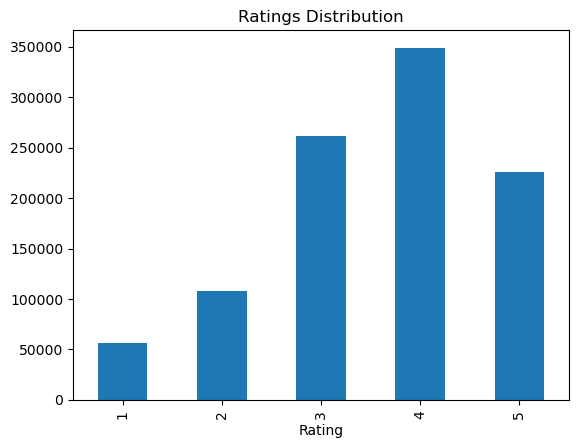

In [12]:
ratings['Rating'].value_counts().sort_index().plot(kind='bar', title='Ratings Distribution')

This histogram shows how frequently each movie was rated. Many movies have very few ratings, which can affect collaborative filtering due to data sparsity.

<Axes: >

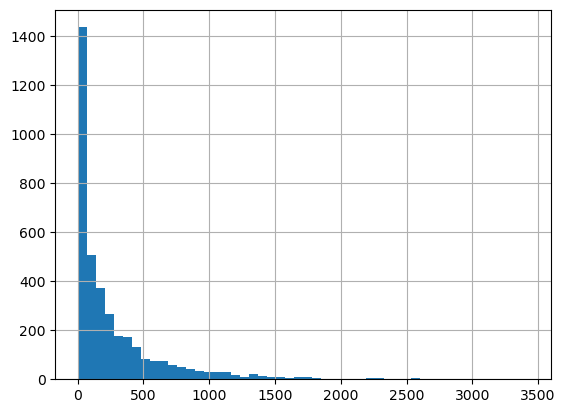

In [13]:
ratings['MovieID'].value_counts().hist(bins=50)

This plot displays how active the users are. While a few users have rated hundreds of movies, most users have rated only a handful, again highlighting sparsity challenges.

<Axes: >

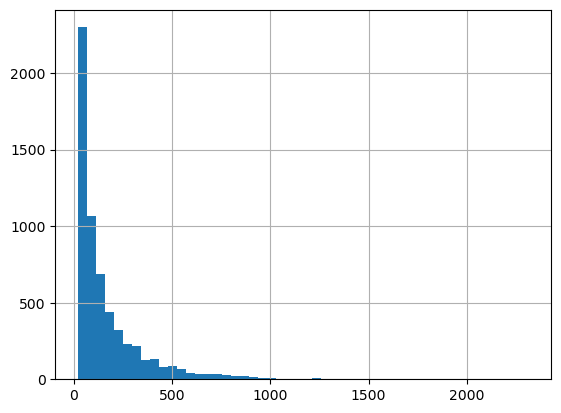

In [14]:
ratings['UserID'].value_counts().hist(bins=50)

This bar chart shows the ten most frequently rated movies in the dataset. These titles serve as good candidates for popularity-based recommendations or sanity checks in modeling.

<Axes: title={'center': 'Top 10 Most Rated Movies'}, ylabel='Title'>

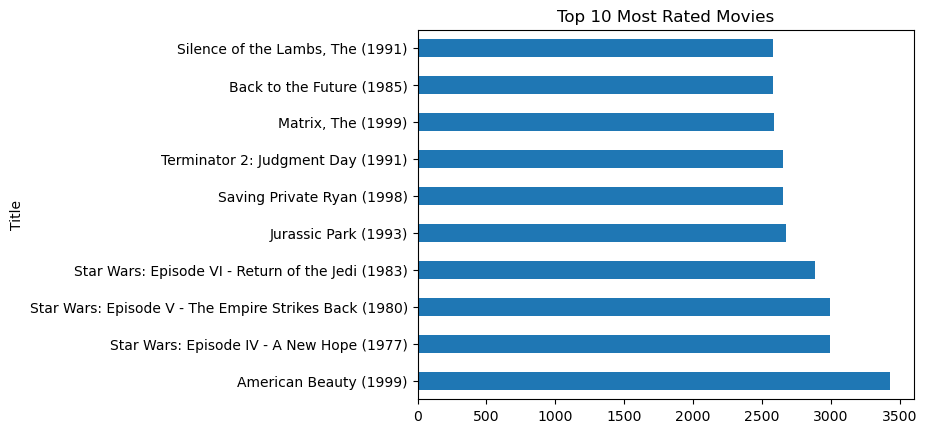

In [15]:
popular = ratings['MovieID'].value_counts().head(10)
popular_titles = movies.set_index('MovieID').loc[popular.index]['Title']
pd.Series(popular.values, index=popular_titles).plot(kind='barh', title='Top 10 Most Rated Movies')

This chart summarizes how genres are represented in the dataset. Some genres like "Drama" and "Comedy" are far more common, which may influence model bias or performance.

<Axes: title={'center': 'Genre Distribution'}>

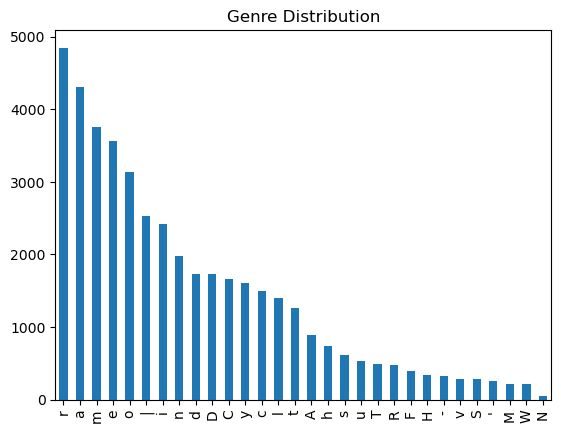

In [16]:
from collections import Counter
import matplotlib.pyplot as plt

genre_counts = Counter([g for sublist in movies['Genres'] for g in sublist])
pd.Series(genre_counts).sort_values(ascending=False).plot(kind='bar', title='Genre Distribution')
